# COVID-19 and Urban Air Pollution

New York Univeristy CS-GY 6513 Spring 2020 Final Project

Tianrun Wang (tw969), Raymond Dee (rmd377), Jonathan Pun (jp5474)

## Abstract

The public health crisis caused by the Novel Coronavirus (COVID-19) prompted governments worldwide to restrict human movement in a bid to limit the spread of the respiratory disease. Since the outbreak in March 2020 in the United States, many states and municipalities have issued stay-at-home orders, and economic activity has been largely reduced to essential services only. The unprecedented restriction on economic activity has led to a significant drop in traffic volume, factory production, and other sources widely attributted to urban air pollution, leading to a substantial improvement in air quality in major U.S. cities.

In this project, we analyze the relationship between the severity of COVID-19 outbreak in a city and the improvement of air quality. We will primarily focus our analysis on the experience of New York City, due to the quality and availability of its high-frequency data on ground traffic, air pollution and COVID-19 case count.

## Notebook Setup

In [52]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Wrangling and Overview

### 1. EPA Air Quality Data

In [53]:
# EPA daily air quality data in 2019 and 2020
aqi19 = pd.read_csv('data/aqidaily2019.csv')
aqi20 = pd.read_csv('data/aqidaily2020.csv')

# concat rows
aqi = pd.concat([aqi19, aqi20], axis=0)

# parse Date column to datetime and set as index, sort ascending
aqi['Date'] = pd.to_datetime(aqi['Date'], format='%m/%d/%Y')
aqi.set_index('Date', inplace=True)
aqi.sort_index(inplace=True)

In [54]:
aqi.head()

,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,SO2,PM10,PM25,NO2
Date,,,,,,,,,,,
2019-01-01,45,PM2.5,MASPETH LIBRARY,36-081-0120,AQS,6,30,0,.,45,38
2019-01-02,64,PM2.5,PS 19,36-061-0128,AQS,7,29,6,.,64,32
2019-01-03,54,PM2.5,PS 19,36-061-0128,AQS,6,26,3,11,54,37
2019-01-04,60,PM2.5,Elizabeth Lab,34-039-0004,AQS,9,20,6,.,60,34
2019-01-05,50,PM2.5,DIVISION STREET,36-061-0134,AQS,9,26,33,.,50,31


In [55]:
len(aqi)

480

The dataframe consists of daily observations of air quality index and 6 pollutants in the metropolitan New York area ranging from 2019-01-01 to 2020-04-24. We will use Overall AQI Value as the primary gauge of air quality, quoting EPA, "AQI is a measure that runs from 0 to 500. The higher the AQI value, the greater the level of air pollution and the greater the health concern. For example, an AQI value of 50 or below represents good air quality, while an AQI value over 300 represents hazardous air quality".

An interesting observation just by looking at the top 5 rows is that PM2.5 seems to be the main pollutant in New York City, let's examine the dataframe more closely.

In [56]:
# group by Main Pollutant and count
aqi.groupby(['Main Pollutant']).count()

,Overall AQI Value,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,SO2,PM10,PM25,NO2
Main Pollutant,,,,,,,,,,
NO2,61,61,61,61,61,61,61,61,61,61
Ozone,190,190,190,190,190,190,190,190,190,190
PM2.5,229,229,229,229,229,229,229,229,229,229


We see that PM2.5 prevails as the major pollutant in NYC area in close to half of the days for the past 16 months. PM2.5 is defined as fine particles with a diameter of 2.5 μm or less, and is often emitted by automobile engines and industrial fuel consumption, according to [Wikipedia](https://en.wikipedia.org/wiki/Particulates#Sources_of_atmospheric_particulate_matter). This is consistent with our hypothesis that the improvement in air quality is due to the reduction of ground traffic caused by COVID-19 shutdowns.

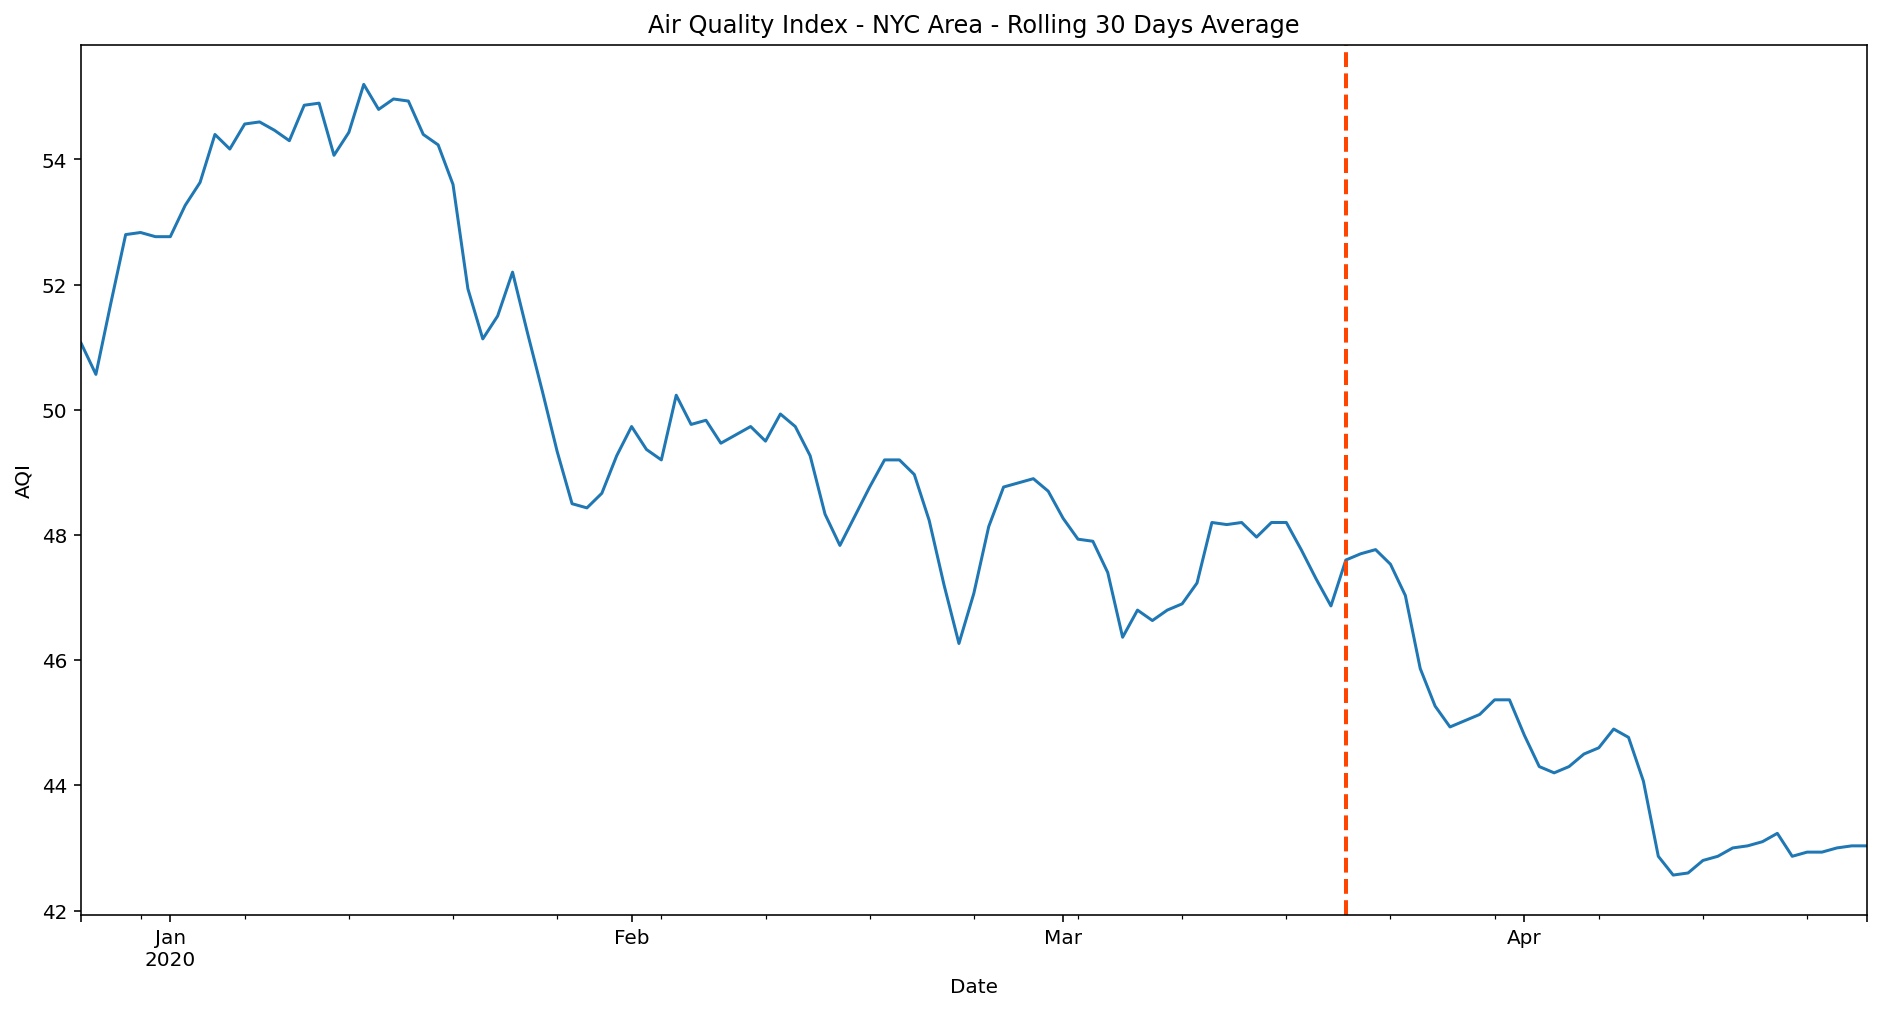

In [57]:
# AQI trend from January to April 2020, 30-day average
ax = aqi['Overall AQI Value'].tail(150).rolling(30).mean().dropna().plot(figsize=(16, 8))
_ = ax.axvline('2020-03-20', color='orangered', linestyle='--', lw=2, alpha=1.0)
_ = ax.set_ylabel('AQI')
_ = ax.set_title('Air Quality Index - NYC Area - Rolling 30 Days Average')

We see a significant drop in Air Quality Index (better air quality) since New York State issued the stay-at-home order on March 20 (red line), which directed all non-essential workers to work from home.

### 2. MTA Daily Traffic Data

We derived the daily traffic volume data from the Hourly Traffic on Metropolitan Transportation Authority (MTA) Bridges and Tunnels dataset found on [Open NY](https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga). As the original dataset features 1.59 million rows, we chose to only include the 2019 and 2020 data in our repo, which has about 191,000 rows, and it looks like this

In [58]:
mta_hourly = pd.read_csv('data/mta_hourly_traffic.csv', nrows=5)
mta_hourly.head()

,Plaza_ID,Date,Hour,Direction,Vehicles_ETC,Vehicles_cash
0,21,04/18/2020,0,I,517,130
1,21,04/18/2020,1,I,305,92
2,21,04/18/2020,2,I,219,76
3,21,04/18/2020,3,I,229,65
4,21,04/18/2020,4,I,368,56


Where Plaza ID identifies the toll plaza of a bridge or tunnel, Hour identifies the hour of the Date, Direction is a binary indicator that is either inbound (I) or outbound (O), Vehicles_ETC is the number of vehicles that pass through a toll station using E-ZPass each hour, and Vehicles_cash is that of the vehicles using cash.

To be consistent with other datasets we are using, we choose to aggregate hourly traffic volume into daily volume. As the orignal file is rather large, we did this part of the data wrangling on NYU's dumbo system using Spark SQL. The SQL statement we used to generate `mta_daily_traffic.csv` is as follows

```sql
SELECT `Date`, sum(Vehicles_ETC) AS Vehicles_ETC, sum(Vehicles_cash) AS Vehicles_cash FROM mta_hourly 
WHERE Date LIKE '%/2019' OR `Date` LIKE '%/2020' GROUP BY `Date`;
```

In [59]:
# MTA daily traffic through bridges and tunnels
mta_daily = pd.read_csv('data/mta_daily_traffic.csv')

# parse Date column to datetime and set as index, sort ascending
mta_daily['Date'] = pd.to_datetime(mta_daily['Date'], format='%m/%d/%y')
mta_daily.set_index('Date', inplace=True)
mta_daily.sort_index(inplace=True)

# we are interested in the total throughput
mta_daily['Vehicles_Total'] = mta_daily.sum(axis=1)

In [60]:
mta_daily.head()

,Vehicles_ETC,Vehicles_cash,Vehicles_Total
Date,,,
2019-01-01,507979,87764,595743
2019-01-02,633083,84992,718075
2019-01-03,658237,84787,743024
2019-01-04,668302,90224,758526
2019-01-05,543013,85487,628500


In [61]:
len(mta_daily)

470

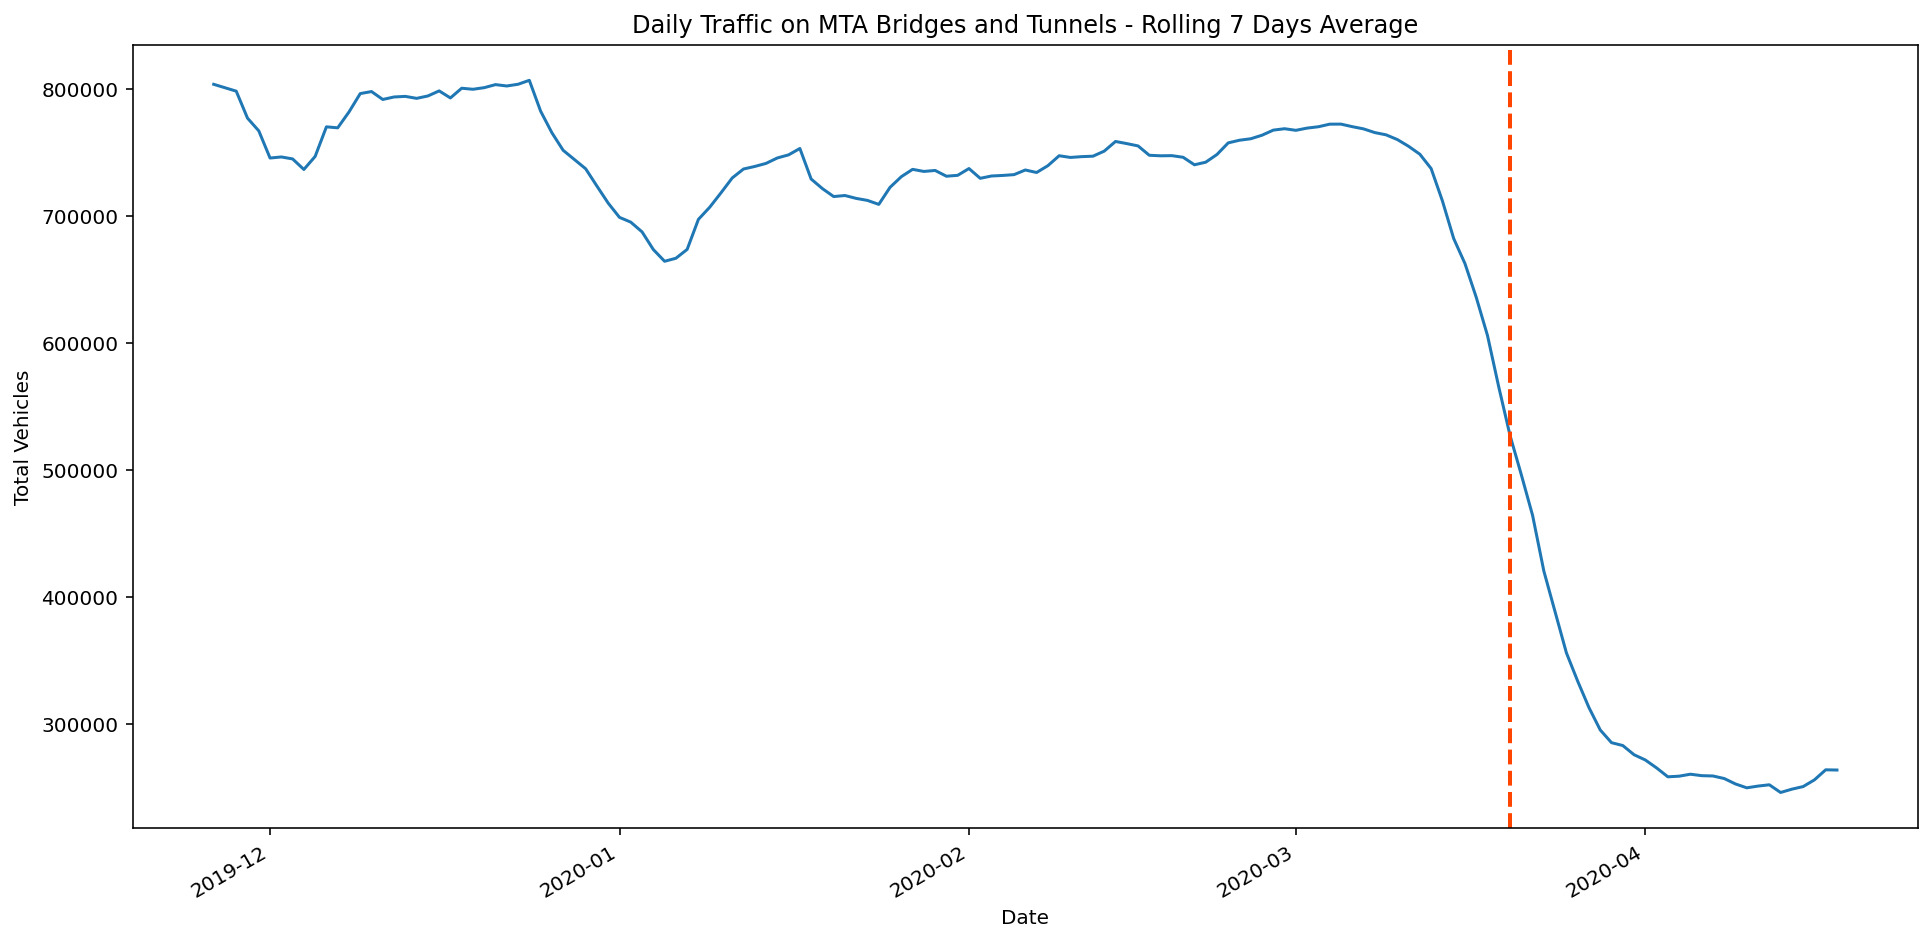

In [65]:
# trend of total vehicles passing thru bridges and tunnels
ax = mta_daily['Vehicles_Total'].tail(150).rolling(7).mean().dropna().plot(figsize=(16, 8))
_ = ax.axvline('2020-03-20', color='orangered', linestyle='--', lw=2, alpha=1.0)
_ = ax.set_ylabel('Total Vehicles')
_ = ax.set_title('Daily Traffic on MTA Bridges and Tunnels - Rolling 7 Days Average')

We see a significant drop in total vehicles on MTA bridges and tunnels since New York State issued the stay-at-home order on March 20 (red line), which directed all non-essential workers to work from home.

### 3. Johns Hopkins COVID-19 Data